# Disaster Tweet Classification

Binary classification of disaster-related tweets using TF-IDF and machine learning.

### 1 - Notebook Overview

**Goal:** Predict whether a tweet is about a real disaster (1) or not (0), using the [Kaggle Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started) dataset of 7,613 labeled tweets.

**Pipeline:**

1. Load and inspect the dataset
2. Preprocess tweet text (lowercasing, removing URLs/mentions/special characters, stop word removal, lemmatization)
3. Vectorize text using TF-IDF
4. Train a Logistic Regression baseline model
5. Evaluate with accuracy, precision, recall, F1-score, and confusion matrix
6. Optional: hyperparameter tuning and cross-validation

**Dataset:** `train.csv` with columns `text` (tweet content) and `target` (1 = disaster, 0 = not disaster).

### 2 - Import Libraries

In [7]:
# Code liraries
import pandas as pd

# Visualisations
import matplotlib.pyplot as plt

### 3 - Load & Explore Dataset

In [4]:
# Import the training dataset
train_data = pd.read_csv("../data/train.csv")

# Check shape of the training dataset and view the first few rows
print(f"Shape of training dataset: {train_data.shape}")
train_data.head()

Shape of training dataset: (7613, 2)


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


text           0
target         0
text_length    0
dtype: int64

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


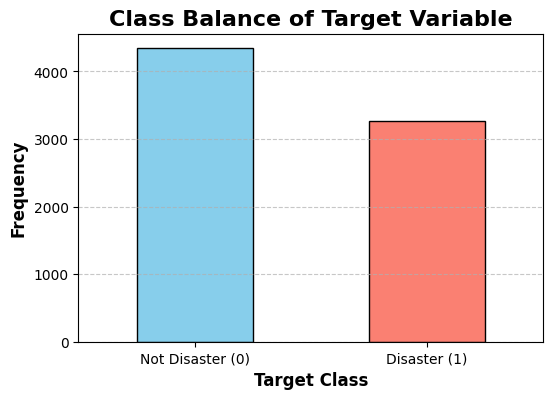

In [ ]:
# Check for missing values and class balance
print(train_data.isnull().sum())
print()
print(train_data['target'].value_counts(normalize=True))

# Visualize class balance with labels 0 = not a disaster, 1 = disaster
plt.figure(figsize=(6, 4))
train_data['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='black')
plt.xlabel('Target Class', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Class Balance of Target Variable', fontsize=16, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=['Not Disaster (0)', 'Disaster (1)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Export visualization and show
plt.savefig('../visualizations/class_balance.png', dpi=300, bbox_inches='tight')
plt.show()

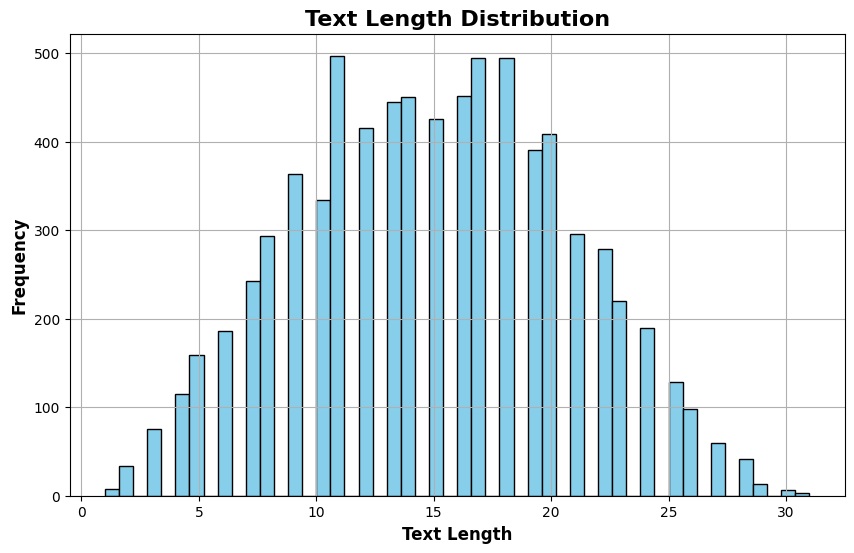

In [11]:
# Review length distribution
train_data['text_length'] = train_data['text'].apply(lambda x: len(x.split()))

# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
train_data['text_length'].hist(bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Text Length', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Text Length Distribution', fontsize=16, fontweight='bold')

# Export visualization and show
plt.savefig('../visualizations/text_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()